In [1]:
conda activate tensorflow


Note: you may need to restart the kernel to use updated packages.


In [78]:
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.display import clear_output
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
from six.moves import urllib
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from statistics import multimode
from sklearn.svm import SVC

import statistics
import os
import shutil
import dlib
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [3]:
dftrain = pd.read_csv('data/xyTrain.csv') # training data based on face landmark tracking
dfeval = pd.read_csv('data/xyTest.csv') # testing data based on face landmark tracking
dfreal = pd.read_csv('data/realMouthCoords.csv') # real face data
y_train = dftrain.pop('happiness')
y_eval = dfeval.pop('happiness')
y_real = dfreal.pop('happiness')

dfjsontrain = pd.read_csv('data/jsonxy_train.csv') # training data based on json files
dfjsoneval = pd.read_csv('data/jsonxy_test.csv') # testing data based on json files
json_train = dfjsontrain.pop('happiness')
json_eval = dfjsoneval.pop('happiness')

In [4]:
NUMERIC_COLUMNS = ['mouth0x', 'mouth0y', 'mouth1x', 'mouth1y', 'mouth2x', 'mouth2y', 'mouth3x', 'mouth3y', 'mouth4x', 'mouth4y',
         'mouth5x', 'mouth5y', 'mouth6x', 'mouth6y', 'mouth7x', 'mouth7y', 'mouth8x', 'mouth8y', 'mouth9x', 'mouth9y',
         'mouth10x', 'mouth10y', 'mouth11x', 'mouth11y', 'mouth12x', 'mouth12y', 'mouth13x', 'mouth13y', 'mouth14x',
         'mouth14y', 'mouth15x', 'mouth15y', 'mouth16x', 'mouth16y', 'mouth17x', 'mouth17y', 'mouth18x', 'mouth18y',
         'mouth19x', 'mouth19y']

feature_columns = []
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [84]:
def make_input_fn(data_df, label_df, num_epochs=125, shuffle=True, batch_size=20):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

In [29]:
# Train 10 times to get an average accuracy score
# To train model off facelandmark vs json data change
# dftrain -> dfjsontrain
# y_train -> json_train
# dfeval -> dfjsoneval
# y_eval -> json_eval

i = 0
conclusion = [0] * 10
while i < 10: 
    train_input_fn = make_input_fn(dftrain, y_train)
    eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

    linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

    linear_est.train(train_input_fn)
    result = linear_est.evaluate(eval_input_fn)

    clear_output()
    conclusion[i] = result['accuracy']
    print(result['accuracy'])
    i += 1
    print(i)
i = 0    
clear_output()
while i < 10:
    print(conclusion[i])
    i += 1

0.8035
0.7925
0.877
0.8045
0.8595
0.87
0.8435
0.831
0.8725
0.8765


In [85]:
# Train once
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
conclusion = result['accuracy']
print(result['accuracy'])

0.861


In [25]:
i = 0
probArray = [0] * 2000
lessThan = 0
noSmile = 0
result = list(linear_est.predict(eval_input_fn))
while i < 2000:
    probArray[i] = result[i]['probabilities'][1]
    if (result[i]['probabilities'][1] <= 0.2):
        lessThan += 1
    if (y_eval.loc[i] == 0):
        noSmile += 1
    i += 1
    clear_output()
    print(i)
    print(result[i]['probabilities'][1])  

1496
0.00031625776


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [39]:
probArray.sort()

res = statistics.median(probArray)
print("Amount of predictions less than 0.2 is : " + str(lessThan))
print("Amount of pictures with no smiles is : " + str(noSmile))
print("Mean of the list is : " + str(statistics.mean(probArray)))
print("Median of list is : " + str(res))
print("Mode of list is : " + str(multimode(probArray)))

Amount of predictions less than 0.2 is : 1337
Amount of pictures with no smiles is : 1106
Mean of the list is : 0.29084772
Median of list is : 0.007544670253992081
Mode of list is : [1.0]


In [41]:
location = 100
result = list(linear_est.predict(eval_input_fn))
print(y_eval.loc[location])
print(result[location]['probabilities'][1])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Elliot\AppData\Local\Temp\tmpmbf4d6r_\model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1
0.99910957


In [87]:
# Evaluate prediction score for synthetic faces
location = 5
faceResult = list(linear_est.predict(eval_input_fn))
clear_output()
print(y_real.loc[location])
print(faceResult[location]['probabilities'][1])

0
0.28248298


In [38]:
# Create real faces prediction
# To check eval vs real data change
# real_input_fn -> eval_input_fn

real_input_fn = make_input_fn(dfreal, y_real, num_epochs=1, shuffle=False)

# print(dfreal.loc[i])
# print(y_real.loc[i])
# print(faceResult[i]['probabilities'][1])
# Evaluate prediction score for real faces
i = 0
success = 0
faceValue = [0] * 12
facePrediction = [0] * 12
while i < 12:
    faceResult = list(linear_est.predict(real_input_fn))
    if (y_real.loc[i] == 1) and (faceResult[i]['probabilities'][1] > 0.8):
        success += 1    
        faceValue[i] =  y_real.loc[i]
        facePrediction[i] = faceResult[i]['probabilities'][1]
    elif (y_real.loc[i] == 0) and (faceResult[i]['probabilities'][1] < 0.2):  
        success += 1
        faceValue[i] =  y_real.loc[i]
        facePrediction[i] = faceResult[i]['probabilities'][1]
    else:
        faceValue[i] =  y_real.loc[i]
        facePrediction[i] = faceResult[i]['probabilities'][1]
    i += 1    
clear_output()        
print("Out of 12 pictures, the model predicted " + str(success) + " correctly")
i = 0
while i < 12:
    print(str(faceValue[i]) + " - " + str(facePrediction[i]))
    i += 1

Out of 12 pictures, the model predicted 7 correctly
0 - 4.8024496e-05
1 - 0.99935085
1 - 1.0
0 - 1.0
1 - 0.9999974
0 - 0.2982656
0 - 0.14117838
1 - 1.0
0 - 0.71654904
0 - 0.81341815
0 - 0.9935389
0 - 0.0008084449


AUC Score is 0.9495496397522564


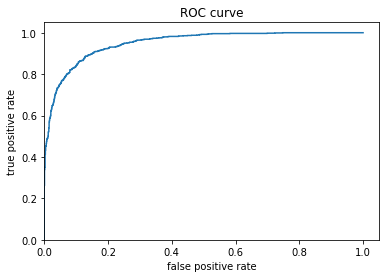

In [46]:
# Generating an ROC curve and AUC score of evaluation data
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])
fpr, tpr, _ = roc_curve(y_eval, probs)
aucScore = roc_auc_score(y_eval, probs)
clear_output()
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
print("AUC Score is " + str(aucScore))

INFO:tensorflow:Calling model_fn.


C:\Users\Elliot\anaconda3\lib\site-packages\tensorflow_estimator\python\estimator\canned\linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Elliot\AppData\Local\Temp\tmpmbf4d6r_\model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1106
894
[[982 124]
 [123 771]]


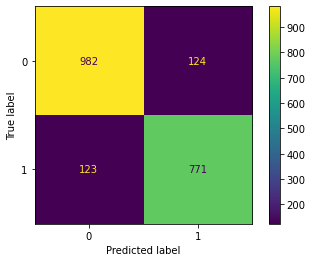

In [83]:
resultArray = [0] * 2000
predArray = [0] * 2000
prediction = list(linear_est.predict(eval_input_fn))
i = 0
while i < 2000:
    resultArray[i] = y_eval.loc[i]
    if (prediction[i]['probabilities'][1] > 0.5):
        predArray[i] = 1
    else:
        predArray[i] = 0 
    i += 1
    
clf = SVC(random_state=0)
clf.fit(dftrain, y_train)
SVC(random_state=0)
    
print(resultArray.count(0))
print(resultArray.count(1)) 
print(confusion_matrix(resultArray, predArray))
cm = confusion_matrix(resultArray, predArray)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
# Saves model
inputFn = \
tf.estimator.export.build_parsing_serving_input_receiver_fn(
  tf.feature_column.make_parse_example_spec(feature_columns))
OUTDIR = 'modelDir'
shutil.rmtree(OUTDIR, ignore_errors = True)
modelBasePath = os.path.join(OUTDIR, "model")
modelPath = linear_est.export_saved_model(modelBasePath, inputFn)